<a href="https://www.kaggle.com/code/josephjesuraja/aptos-2019-v1?scriptVersionId=239524171" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Diabetic Retinopathy Detection using Deep Learning (APTOS 2019)

## 🎯 Objective

The primary goal of this project is to design and implement a deep learning-based solution to automatically classify retinal fundus images into five distinct stages of diabetic retinopathy, ranging from no disease to the most severe form.

This work aims to contribute to the growing field of medical image analysis by developing a scalable and reliable model that can assist in early diagnosis and treatment planning. The model leverages convolutional neural networks (CNNs), which are particularly well-suited for extracting patterns and features from high-resolution images.

**Research Question**:  
*To what extent can a convolutional neural network (CNN) accurately detect and classify the severity of diabetic retinopathy from retinal fundus images in a clinically meaningful way, using a challenging real-world dataset such as APTOS 2019?*


## 🌍 Real-World Impact

Diabetic retinopathy is a serious complication of diabetes and one of the leading causes of vision impairment and blindness globally, particularly among working-age adults. Detecting it in its early stages is critical to prevent permanent vision loss, yet the manual examination of retinal fundus images by ophthalmologists is time-consuming, expensive, and prone to variability between practitioners.

The dataset used in this project — from the APTOS 2019 Blindness Detection Kaggle competition — represents a real-world medical imaging challenge. It includes high-resolution retinal images labeled by clinical experts into five levels of diabetic retinopathy severity. However, the dataset is known for its complexity due to:
- **High intra-class variability**: The same class of severity can visually appear very different.
- **Image quality issues**: Many images suffer from blur, lighting variations, and noise.
- **Class imbalance**: The dataset has significantly more healthy cases than severe ones, requiring careful preprocessing and augmentation.

These challenges make it an ideal test case for deep learning techniques in medical image processing. Successfully building an automated system on such a dataset not only demonstrates technical proficiency but also addresses a real-world healthcare need with the potential for large-scale impact.


## 🗂️ Overview
This notebook walks through:
- Dataset description and visualization
- Preprocessing and augmentation techniques
- Deep learning model architecture
- Training, validation, and evaluation of results
- Performance metrics and confusion matrix
- Critical analysis and conclusion


In [1]:

# 1. Imports
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

from tensorflow.keras.applications import EfficientNetB0 # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
import warnings
warnings.filterwarnings("ignore")
print("done")


2025-05-13 17:34:49.613513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747157689.811914      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747157689.871839      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


done


In [2]:
WORKERS = 2
CHANNEL = 3
# Constants

IMG_SIZE = 512

NUM_CLASSES = 5
SEED = 42
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train

AUTOTUNE = tf.data.experimental.AUTOTUNE
TEST_IMAGE_FOLDER = "../input/aptos2019-blindness-detection/test_images" 
TRAIN_IMAGE_FOLDER = "../input/aptos2019-blindness-detection/train_images"
BATCH_SIZE = 32
print("done")

done


# Data Loading and Preprocessing

diagnosis
0    1805
1     370
2     999
3     193
4     295
Name: count, dtype: int64


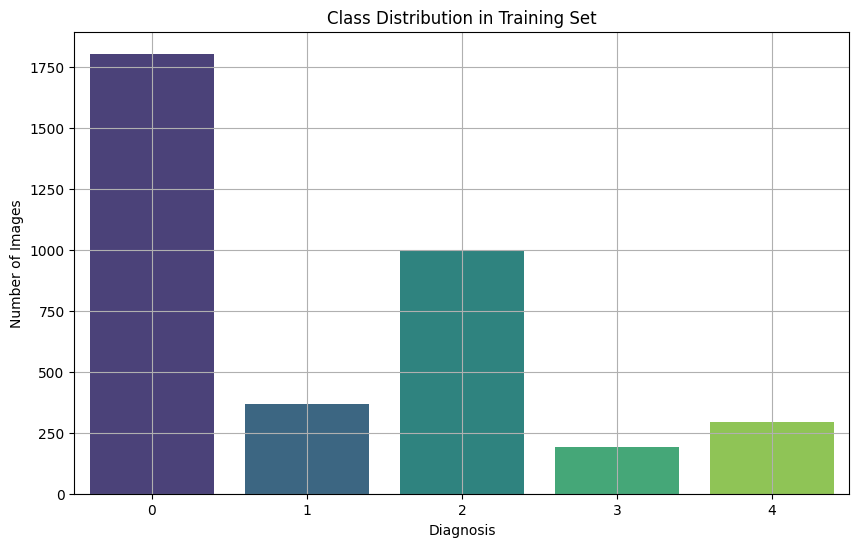

done


In [3]:

# Load the dataset
df_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')  # test has no 'diagnosis'

# Split train into features and labels
x = df_train['id_code']
y = df_train['diagnosis']

# Shuffle with a fixed seed to ensure reproducibility
x, y = shuffle(x, y, random_state=SEED)

# Add shuffled values back to a DataFrame for easier visualization
df_train_shuffled = pd.DataFrame({'id_code': x, 'diagnosis': y})

# No labels in test set
x_test = df_test['id_code']
df_test_clean = pd.DataFrame({'id_code': x_test})  # No 'diagnosis' column

# Count number of samples in each class (for training only)
class_counts = df_train_shuffled['diagnosis'].value_counts().sort_index()
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Class Distribution in Training Set")
plt.xlabel("Diagnosis")
plt.ylabel("Number of Images")
plt.grid(True)
plt.show()
print("done")

# Preprocessing without  CLAHE and  Normalization

In [4]:
'''
def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        cropped_img = img[np.ix_(mask.any(1), mask.any(0))]
        if cropped_img.size == 0:  # Check if the cropped image is empty
            return img
        return cropped_img
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol

        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:  # If the image is too dark and cropping out everything
            return img
        img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
        img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
        img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
        img = np.stack([img1, img2, img3], axis=-1)

        if img.size == 0:  # Check if the cropped image is empty
            return img
        return img

def preprocess_image(path, img_size=512, apply_circle_crop=True, apply_unsharp=True, to_grayscale=False):
    img = cv2.imread(path)

    if img is None:
        raise ValueError(f"Image at path {path} not found.")

    img = crop_image_from_gray(img)

    if apply_circle_crop:
        h, w = img.shape[:2]
        x, y = w // 2, h // 2
        r = min(x, y)
        mask = np.zeros((h, w), np.uint8)
        cv2.circle(mask, (x, y), r, 1, -1)
        img = cv2.bitwise_and(img, img, mask=mask)
        img = crop_image_from_gray(img)  # Crop again to ensure the central area is clean

    if to_grayscale:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = cv2.resize(img, (img_size, img_size))

    if apply_unsharp:
        img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), img_size / 10), -4, 128)

    return img
    
'''


'\ndef crop_image_from_gray(img, tol=7):\n    if img.ndim == 2:\n        mask = img > tol\n        cropped_img = img[np.ix_(mask.any(1), mask.any(0))]\n        if cropped_img.size == 0:  # Check if the cropped image is empty\n            return img\n        return cropped_img\n    elif img.ndim == 3:\n        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)\n        mask = gray_img > tol\n\n        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]\n        if check_shape == 0:  # If the image is too dark and cropping out everything\n            return img\n        img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]\n        img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]\n        img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]\n        img = np.stack([img1, img2, img3], axis=-1)\n\n        if img.size == 0:  # Check if the cropped image is empty\n            return img\n        return img\n\ndef preprocess_image(path, img_size=512, apply_circle_crop=Tr

# Preprocessing with CLAHE and  Normalization
Feature	Status	Comments
crop_image_from_gray()	✅	Works for both grayscale and RGB. Handles edge cases (dark images, empty crops).
Circle crop (optional)	✅	Uses center masking and a second crop to remove black borders — very clean.
Grayscale conversion toggle	✅	Controlled by to_grayscale flag — modular.
Resize	✅	Done after cropping and masking, which is optimal.
Unsharp masking	✅	Clean implementation using cv2.addWeighted trick.
Error handling	✅	Checks for image load failure.

In [5]:
import albumentations as A
def get_augmentation_pipeline(img_size: int):
    """
    Define a flexible augmentation pipeline using albumentations.

    Parameters:
    - img_size: Target image size after augmentation.

    Returns:
    - Augmentation pipeline function.
    """
    return A.Compose([
        # A.HorizontalFlip(p=0.7),  # Increased probability for horizontal flip
        # A.VerticalFlip(p=0.5),    # Vertical flip with 50% probability
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),  # Reduced brightness/contrast range
        A.Rotate(limit=15, p=0.5),  # Reduced max rotation to 15 degrees
        A.RandomCrop(width=img_size, height=img_size, p=0.5),  # Random crop
        A.RandomSizedCrop(min_max_height=(int(0.8*img_size), img_size), size=(img_size, img_size), p=0.3)
        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1.0)  # Normalize with ImageNet stats
    ])


def crop_image_from_gray(img: np.ndarray, tol: int = 7) -> np.ndarray:
    """
    Crop out dark regions of the image based on a grayscale threshold.

    Parameters:
    - img: Input image (grayscale or RGB).
    - tol: Pixel intensity threshold below which the region is considered dark.

    Returns:
    - Cropped image with dark borders removed.
    """
    if img.ndim == 2:
        mask = img > tol
        cropped_img = img[np.ix_(mask.any(1), mask.any(0))]
        return cropped_img if cropped_img.size > 0 else img
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        if img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0] == 0:
            return img
        img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
        img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
        img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
        img = np.stack([img1, img2, img3], axis=-1)
        return img if img.size > 0 else img

def apply_clahe_rgb(img: np.ndarray) -> np.ndarray:
    """
    Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to the L-channel of LAB image.

    Parameters:
    - img: Input RGB image.

    Returns:
    - CLAHE-enhanced RGB image.
    """
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

def preprocess_image(
    path: str,
    img_size: int = IMG_SIZE,
    apply_circle_crop: bool = True,
    apply_unsharp: bool = True,
    to_grayscale: bool = False,
    apply_clahe: bool = False,
    normalize: bool = True,
    augment: bool = False 
) -> np.ndarray:
    """
    Full preprocessing pipeline for retinal images.

    Parameters:
    - path: Path to the image file.
    - img_size: Final size to which the image will be resized.
    - apply_circle_crop: Whether to apply circular mask cropping.
    - apply_unsharp: Whether to apply unsharp masking for enhancement.
    - to_grayscale: Convert image to grayscale after processing (if True).
    - apply_clahe: Whether to apply CLAHE for contrast enhancement.
    - normalize: Whether to normalize pixel values to [0, 1].

    Returns:
    - Preprocessed image in BGR format (either float32 or uint8).
    """
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Image at path '{path}' not found.")

    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Remove dark borders
    img = crop_image_from_gray(img)

    # Optional: circular crop using a center mask
    if apply_circle_crop:
        h, w = img.shape[:2]
        x, y = w // 2, h // 2
        r = min(x, y)
        mask = np.zeros((h, w), np.uint8)
        cv2.circle(mask, (x, y), r, 1, -1)
        img = cv2.bitwise_and(img, img, mask=mask)
        img = crop_image_from_gray(img)

    # Optional: enhance contrast using CLAHE
    if apply_clahe:
        img = apply_clahe_rgb(img)

    # Optional: convert to grayscale
    if to_grayscale:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Resize to target dimensions
    img = cv2.resize(img, (img_size, img_size))

    # Optional: apply unsharp masking for detail enhancement
    if apply_unsharp:
        img = cv2.addWeighted(
            img, 4, cv2.GaussianBlur(img, (0, 0), img_size / 10), -4, 128
        )

    if normalize:
        img = img.astype(np.float32) / 255.0
    
     # Apply augmentation if needed
    if augment:
        augmentation_pipeline = get_augmentation_pipeline(img_size)
        # print(f"Before Augmentation - Min: {img.min()}, Max: {img.max()}")
        img = augmentation_pipeline(image=img)["image"]
        # print(f"After Augmentation - Min: {img.min()}, Max: {img.max()}")

     # Optional: normalize pixel values to [0, 1]
    
    # Convert back to BGR for OpenCV compatibility
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    return img

print("done")

done


# check preprocessing for single image

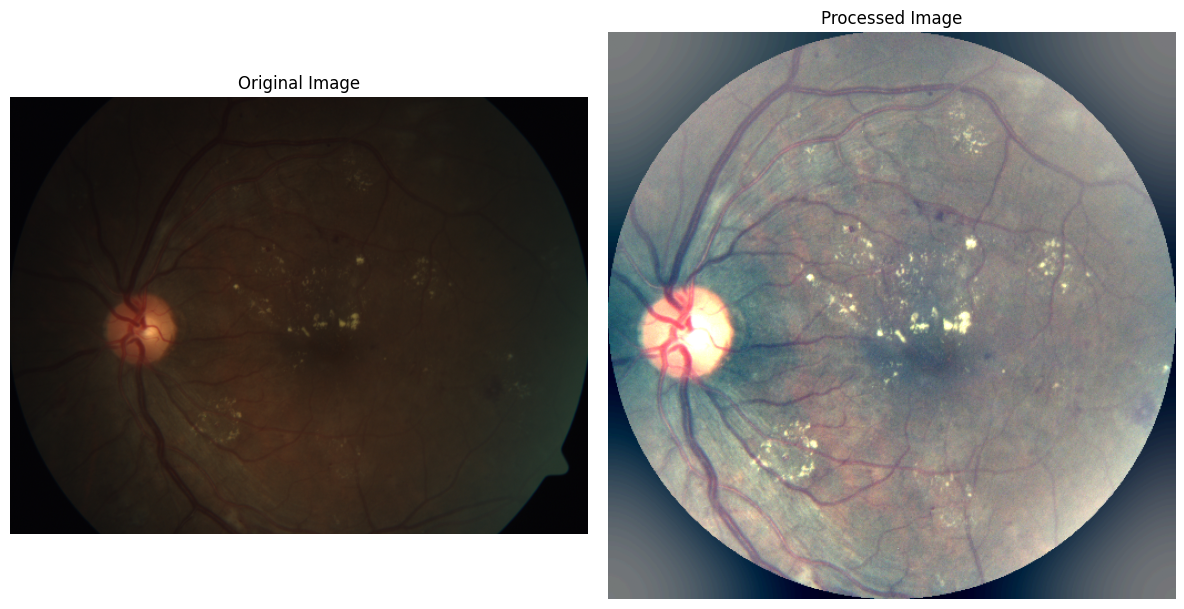

done


In [6]:
image_path = "../input/aptos2019-blindness-detection/test_images/0b121d798018.png"
# image_path = "/Volumes/Brady/project/AI/aptos_blindness_detection/data/test_images/0b121d798018.png"

# Load original image
original_img = cv2.imread(image_path)

# Preprocess image
processed_img = preprocess_image(
    image_path,
    img_size=IMG_SIZE,
    apply_circle_crop=True,
    apply_unsharp=True,
    to_grayscale=False,
    apply_clahe=False,
    normalize=True,
    # augment=True
)

# Convert BGR to RGB for matplotlib display
original_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
processed_rgb = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)

# Plot side-by-side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(processed_rgb)
plt.title("Processed Image")
plt.axis('off')

plt.tight_layout()
plt.show()


# #just because we are normalizing we need to convert back to [0,255] as uint8
if processed_img.dtype == np.float32 or processed_img.max() <= 1.0:
    save_img = (processed_img * 255).clip(0, 255).astype(np.uint8)
else:
    save_img = processed_img  # Already uint8

cv2.imwrite("../input/aptos2019-blindness-detection/processed_image2.jpg", save_img)

# Save processed image
# cv2.imwrite("processed_image2.jpg", processed_img)
print("done")

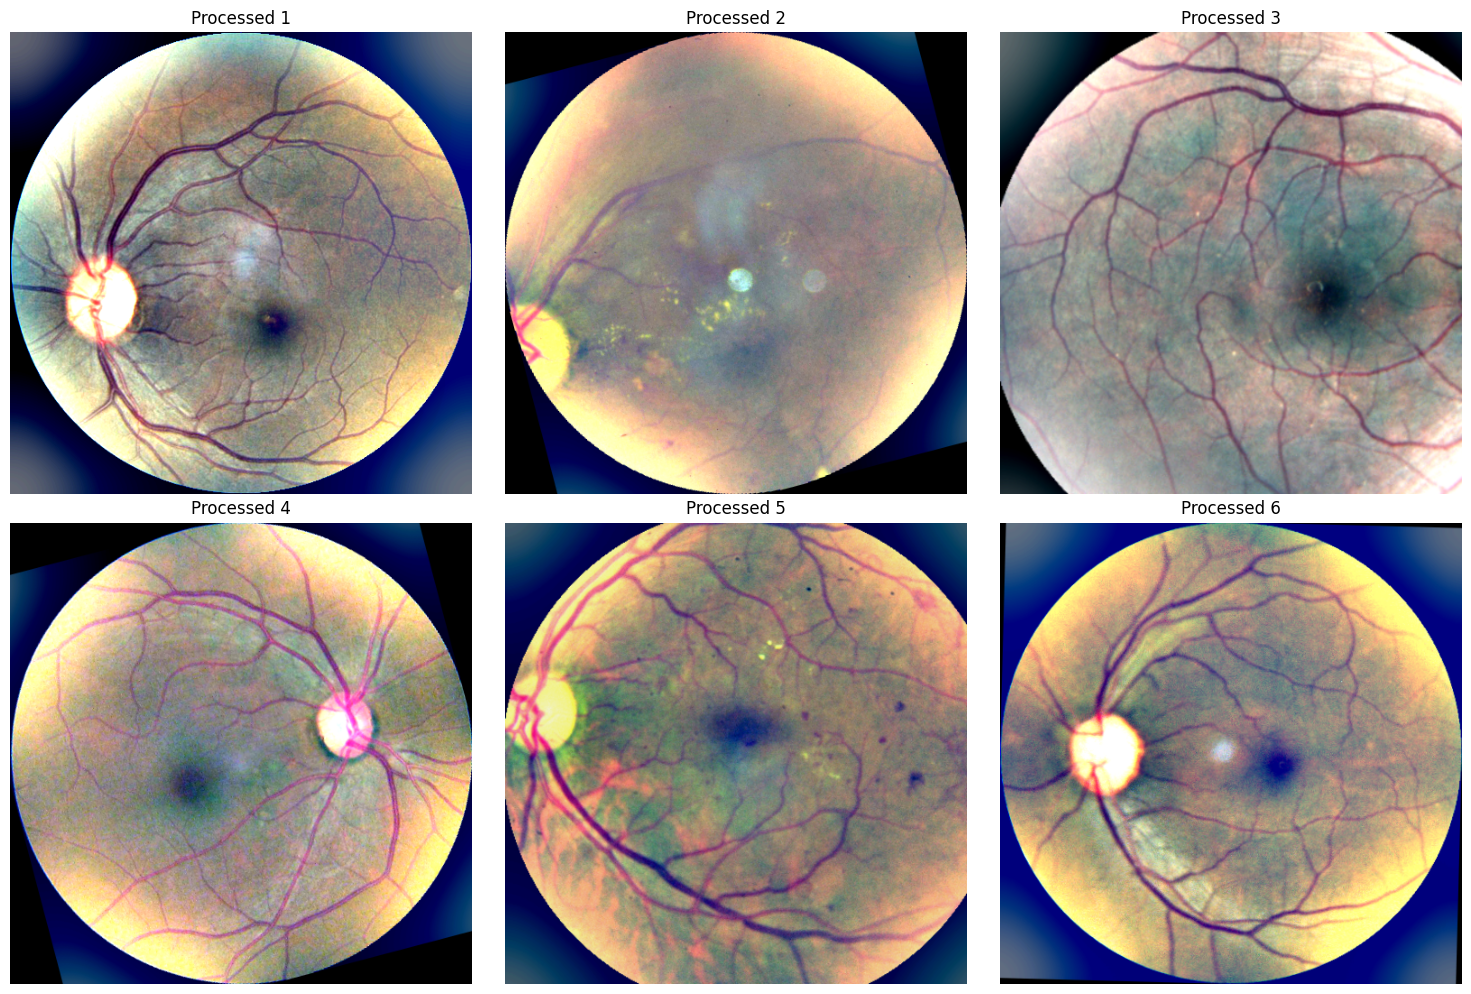

done


In [7]:
import matplotlib.pyplot as plt
import glob

def show_preprocessed_images(folder_path, num_images=6):
    image_paths = glob.glob(folder_path + "/*.png")[:num_images]
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    for i, ax in enumerate(axes.flat):
        if i < len(image_paths):

            img = preprocess_image(
                image_paths[i], 
                img_size=IMG_SIZE,
                apply_circle_crop=True,
                apply_unsharp=True,
                to_grayscale=False,
                apply_clahe=False, 
                normalize=False,
                augment=True
            )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
            ax.set_title(f"Processed {i+1}")
            ax.axis("off")
        else:
            ax.axis("off")
    plt.tight_layout()
    plt.show()
# Just pass your test image folder
show_preprocessed_images("../input/aptos2019-blindness-detection/train_images")
print("done")

In [8]:
# Helper: Load and preprocess image using your custom function
# Function to preprocess image in TensorFlow pipeline
def load_and_preprocess_tf(path, label,augment=False):
    # Convert TensorFlow tensors to numpy values
    try:
        img_path = path.numpy().decode("utf-8")
    except AttributeError:
        raise ValueError("Input path is not a Tensor with .numpy() available.")

    
    # Call your custom preprocessing function
    img = preprocess_image(
        img_path,
        img_size=IMG_SIZE,
        apply_circle_crop=True,
        apply_unsharp=True,
        to_grayscale=False,
        apply_clahe=False,
        normalize=False,
        augment=augment  # Set True only for training
    )
    
    return img, label


# TF wrapper for `load_and_preprocess_tf` so it can be used in graph mode
def tf_preprocess_wrapper(path, label,augment=False):
    img, label = tf.py_function(
        load_and_preprocess_tf, 
        [path, label,tf.constant(augment)], 
        [tf.float32, tf.int64]
    )
    img.set_shape((IMG_SIZE, IMG_SIZE, 3))  # Ensure static shape
    label.set_shape([])
    return img, label

# Prepare dataset
def get_tf_dataset(df, augment=False, batch_size=BATCH_SIZE, shuffle=True,image_folder=TRAIN_IMAGE_FOLDER,has_labels=True):
    image_paths = df['id_code'].apply(lambda x: os.path.join(image_folder, f"{x}.png")).values

    if has_labels:
        labels = df['diagnosis'].astype('int64').values
        ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
        if shuffle:
            ds = ds.shuffle(buffer_size=len(df), seed=SEED)
        ds = ds.map(lambda path, label: tf_preprocess_wrapper(path, label, augment),
                    num_parallel_calls=tf.data.experimental.AUTOTUNE)
    else:
        dummy_labels = np.zeros(len(df), dtype='int64')  # Labels are placeholders
        ds = tf.data.Dataset.from_tensor_slices((image_paths, dummy_labels))
        ds = ds.map(lambda path, label: tf_preprocess_wrapper(path, label, augment),
                    num_parallel_calls=tf.data.experimental.AUTOTUNE)

    ds = ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return ds


from sklearn.model_selection import train_test_split
df_train_split, df_val_split = train_test_split(df_train_shuffled, test_size=0.2, stratify=df_train_shuffled['diagnosis'], random_state=SEED)

# Get TensorFlow Datasets
train_ds = get_tf_dataset(df_train_split, augment=True, batch_size=BATCH_SIZE)
val_ds = get_tf_dataset(df_val_split, augment=False, batch_size=BATCH_SIZE)
test_ds = get_tf_dataset(df_test, augment=False, batch_size=BATCH_SIZE,image_folder=TEST_IMAGE_FOLDER,has_labels=False)



print("done")

I0000 00:00:1747157745.903659      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747157745.904337      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


done


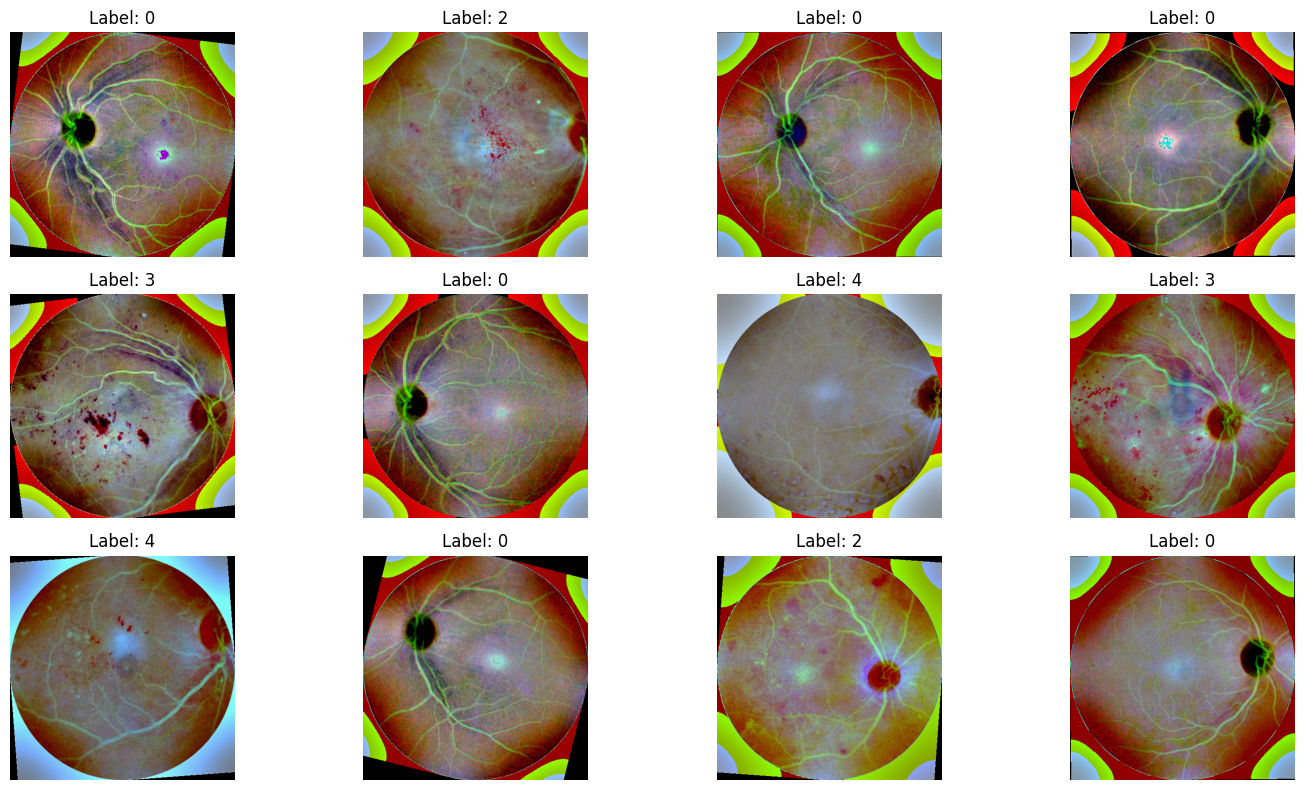

done


In [9]:
# Visualize a batch from the dataset
import matplotlib.pyplot as plt

# Get a batch from train_ds
for images, labels in train_ds.take(1):  # Take one batch
    plt.figure(figsize=(15, 8))
    for i in range(min(12, len(images))):
        ax = plt.subplot(3, 4, i + 1)
        img = images[i].numpy()
        img = (img * 255).astype("uint8")  # Optional: rescale to viewable range
        plt.imshow(img)
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break
print("done")

# CNN model 
## phase 1

### build model

In [10]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0  # or any other base
from tensorflow.keras.optimizers import Adam

def build_model(num_classes=5, input_shape=(IMG_SIZE, IMG_SIZE, 3), base_trainable=False,learning_rate = 1e-4):
    # Load a pre-trained base model (no top/classification layers)
    base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = base_trainable  # Freeze or unfreeze

    # Build the model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model
print("done")

done


In [11]:
# Check the dataset by iterating through the batches
for image, label in train_ds.take(3):  # Take 3 batches
    print(image.shape)
    print(label.shape)

(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)


In [12]:
print("Number of batches in train dataset:", len(train_ds))
print("Number of batches in validation dataset:", len(val_ds))
print("Number of batches in train dataset:", train_ds.cardinality())
print("Number of batches in validation dataset:", val_ds.cardinality())


Number of batches in train dataset: 92
Number of batches in validation dataset: 23
Number of batches in train dataset: tf.Tensor(92, shape=(), dtype=int64)
Number of batches in validation dataset: tf.Tensor(23, shape=(), dtype=int64)


# analysing te class destribution

In [13]:
# from sklearn.utils.class_weight import compute_class_weight
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #type:ignore
# from tensorflow.keras.callbacks import ReduceLROnPlateau # type: ignore


# # Create an empty list to store all labels
# y_train = []

# # Iterate through the dataset to get all labels
# for images, labels in train_ds:
#     y_train.extend(labels.numpy())  # Extend with the labels from each batch

# y_train = np.array(y_train)  # Convert to NumPy array

# # Calculate class weights
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )


# class_weights = dict(enumerate(class_weights))

# print(f"Class Weights: {class_weights}")
from sklearn.utils.class_weight import compute_class_weight

# Fast, no need to loop through dataset
y_train = df_train_split['diagnosis'].values

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print(f"✅ Class Weights: ")
for i,j in class_weights.items():
    print(i,j)

✅ Class Weights: 
0 0.4056786703601108
1 1.979054054054054
2 0.7331664580725907
3 3.803896103896104
4 2.4822033898305085


# Training with callbacks

In [14]:

# # Prepare train and validation datasets
# # train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE)  # Repeat train dataset
# # val_ds = val_ds.batch(BATCH_SIZE)



# # Callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7
# )

# # Train the model
# history = model.fit(
#     train_ds,
#     class_weight=class_weights,
#     validation_data=val_ds,
#     epochs=2,
#     callbacks=[early_stopping, model_checkpoint,reduce_lr],
#     verbose=1
# )



# unfreeze for fine tuning

In [15]:
# # Unfreeze the top layers of the base model for fine-tuning
# base_model.trainable = True
# # Fine-tune from a certain layer
# fine_tune_at = 100  # Unfreeze from layer 100 onwards
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False

# # Re-compile the model after unfreezing layers
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )



# history_fine = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     initial_epoch=history.epoch[-1] + 1,  # continue from where it left off
#     epochs=20,
#     # callbacks=[early_stopping, model_checkpoint],
#     callbacks=[early_stopping, model_checkpoint, reduce_lr],
#     verbose=1
# )

In [16]:
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# import pandas as pd

# # Define hyperparameter ranges
# learning_rates = [1e-4, 1e-3, 1e-2]
# batch_sizes = [16, 32, 64]

# # For storing experiment results
# results = []

# # Loop over all combinations
# for lr in learning_rates:
#     for batch_size in batch_sizes:
#         print(f"\n🔧 Training with Learning Rate: {lr} and Batch Size: {batch_size}")

#         # Rebuild the model (replace this with your model architecture function)
#         model = build_model()  # You must define this function somewhere

#         # Compile with new learning rate
#         optimizer = Adam(learning_rate=lr)
#         model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#         # Callbacks (checkpoint has unique name)
#         checkpoint_path = f"model_lr{lr}_bs{batch_size}.keras"
#         early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#         model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
#         reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
        
#         # i made these 2 changes
#         train_ds = get_tf_dataset(df_train_split, augment=True, batch_size=batch_size)
#         val_ds = get_tf_dataset(df_val_split, augment=True, batch_size=batch_size)
        
        
#         # Train the model
#         history = model.fit(
#             train_ds,
#             validation_data=val_ds,
#             epochs=5,
#             class_weight=class_weights,
#             callbacks=[early_stopping, model_checkpoint, reduce_lr],
#             verbose=1
#         )

#         # Get final validation accuracy/loss
#         val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
#         results.append({
#             "learning_rate": lr,
#             "batch_size": batch_size,
#             "val_accuracy": val_accuracy,
#             "val_loss": val_loss
#         })

# # Convert results to DataFrame and sort by accuracy
# results_df = pd.DataFrame(results).sort_values(by="val_accuracy", ascending=False)
# print("\n🏁 Hyperparameter Tuning Results:")
# print(results_df)

In [17]:
# model = build_model(base_trainable=False, learning_rate=0.001)

# train_ds = get_tf_dataset(df_train_split, augment=True, batch_size=32)
# val_ds = get_tf_dataset(df_val_split, augment=True, batch_size=32)
# # train_ds = get_tf_dataset(df_val_sp, augment=False, batch_size=32)
# test_ds = get_tf_dataset(df_test, augment=False, batch_size=32,image_folder=TEST_IMAGE_FOLDER)

# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=5,
#     class_weight=class_weights,
#     callbacks=[early_stopping, model_checkpoint, reduce_lr],
#     verbose=1
# )

In [18]:
# # Step 2: Fine-tune
# base_model = model.layers[0]  # EfficientNet is the first layer in Sequential
# base_model.trainable = True

# fine_tune_at = 100
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False

# model.compile(
#     optimizer=Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

# history_fine = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     initial_epoch=history.epoch[-1] + 1,
#     epochs=50,
#     callbacks=[early_stopping, model_checkpoint, reduce_lr],
#     verbose=1
# )

# # model.save("best_model.keras")

# Predict single image

In [19]:
# from PIL import Image

# def predict_image(image_path):
#     img = tf.io.read_file(image_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, [512, 512])
#     img = img / 255.0
#     img = tf.expand_dims(img, 0) 

#     preds = model.predict(img)
#     predicted_class = np.argmax(preds, axis=1)[0]
#     print(f"Predicted class: {predicted_class}")
#     return predicted_class

# # Example usage
# predict_image('../data/test_images/0b121d798018.png')

# Using Trained model

In [20]:
from tensorflow.keras.models import load_model

model_path = "/kaggle/input/model_32_512_001_v1/tensorflow2/default/1/final_trained_model.keras"
model = load_model(model_path)

print("✅ Model loaded successfully!")


✅ Model loaded successfully!


# process a single image prediction

I0000 00:00:1747157807.383088      69 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


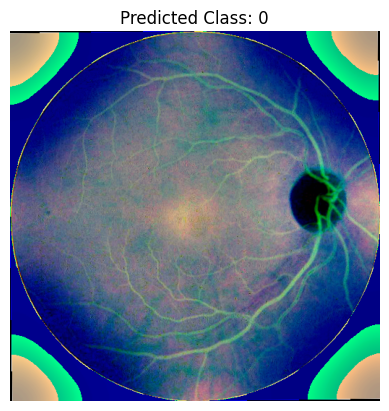

Predicted class: 0


In [21]:
import matplotlib.pyplot as plt
inference_img = preprocess_image(
    path="../input/aptos2019-blindness-detection/test_images/0b121d798018.png", 
    img_size=IMG_SIZE, 
    apply_circle_crop=True,
    apply_unsharp=True,
    to_grayscale=False,
    apply_clahe=False, 
    normalize=False,
    augment=False  # ❗ turn off augmentation for inference
)
img = np.expand_dims(img, axis=0)

pred_probs = model.predict(img)
pred_label = np.argmax(pred_probs, axis=1)[0]


plt.imshow(cv2.cvtColor(img[0], cv2.COLOR_BGR2RGB))
plt.title(f"Predicted Class: {pred_label}")
plt.axis('off')
plt.show()

print("Predicted class:", pred_label)

In [22]:
# def merge_histories(history1, history2):
#     merged_history = {}
#     for key in history1.history.keys():
#         merged_history[key] = history1.history[key] + history2.history.get(key, [])
#     return merged_history

# full_history = merge_histories(history, history_fine)


# import matplotlib.pyplot as plt

# def plot_history(history_dict):
#     acc = history_dict['accuracy']
#     val_acc = history_dict['val_accuracy']
#     loss = history_dict['loss']
#     val_loss = history_dict['val_loss']
#     epochs = range(1, len(acc) + 1)

#     plt.figure(figsize=(14, 5))

#     # Accuracy plot
#     plt.subplot(1, 2, 1)
#     plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
#     plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
#     plt.axvline(x=len(history.history['accuracy']), color='gray', linestyle='--', label='Fine-tuning starts')
#     plt.title('Training and Validation Accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     # Loss plot
#     plt.subplot(1, 2, 2)
#     plt.plot(epochs, loss, 'bo-', label='Training Loss')
#     plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
#     plt.axvline(x=len(history.history['loss']), color='gray', linestyle='--', label='Fine-tuning starts')
#     plt.title('Training and Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

# # Call the function
# plot_history(full_history)


In [23]:
# test_loss, test_accuracy = model.evaluate(test_ds)
# print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

In [24]:
# import numpy as np
# from sklearn.metrics import confusion_matrix, classification_report
# # Get ground truth and predictions
# y_true = []
# y_pred = []

# for images, labels in test_ds:
#     preds = model.predict(images)
#     predicted_labels = np.argmax(preds, axis=1)
#     y_true.extend(labels.numpy())
#     y_pred.extend(predicted_labels)


# # #Generate classification report
# # target_names = [f"Class {i}" for i in range(5)]  # Modify if you have named classes
# # report = classification_report(y_true, y_pred, target_names=target_names)
# # print(report)


# import seaborn as sns
# import matplotlib.pyplot as plt

# # Confusion matrix
# cm = confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(8,6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

# # Classification report
# print("Classification Report:\n")
# print(classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(5)], digits=4))



# Make Prediction and Save prediction to CSV

In [25]:
def predict_and_store_results(test_ds, df_test, output_csv_path):
    """
    Make predictions on the test dataset and store results in a CSV file.

    Parameters:
    - test_ds: TensorFlow dataset containing test images.
    - df_test: DataFrame containing the 'id_code' column (image IDs).
    - output_csv_path: Path to save the predictions CSV file.
    """
    predictions = []
    image_ids = df_test['id_code'].tolist()  # Directly use the list of image IDs

    index = 0  # Track current image index

    for batch_imgs, _ in test_ds:  # Loop through batches
        # Get predictions for the batch
        batch_preds = model.predict(batch_imgs)

        # Convert logits to predicted class indices
        batch_pred_classes = tf.argmax(batch_preds, axis=1).numpy()

        # Append predictions
        predictions.extend(batch_pred_classes)

        # Advance index by batch size (already handled implicitly by ordering)

    # Sanity check
    assert len(predictions) == len(image_ids), f"Mismatch: {len(predictions)} predictions vs {len(image_ids)} ids"

    # Create and save results
    results_df = pd.DataFrame({
        'id_code': image_ids,
        'diagnosis': predictions
    })
    results_df.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to {output_csv_path}")
output_csv_path = "submission.csv"
predict_and_store_results(test_ds,df_test, output_csv_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0